# General import functions

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv
import scanpy.api as sc
from igraph import *
from MulticoreTSNE import MulticoreTSNE as TSNE #faster TSNE alternative
from anndata import read_h5ad
from anndata import read_csv
sc.logging.print_versions()

scanpy==1.4.3+60.gb3dc34a anndata==0.6.22rc1 umap==0.3.9 numpy==1.15.4 scipy==1.3.0 pandas==0.23.4 scikit-learn==0.20.1 statsmodels==0.10.0rc2 python-igraph==0.7.1 louvain==0.6.1


In [12]:
pwd

'/home/ubuntu/maca-data-analysis/sapiens'

# Load the data

In [3]:
import os
pilot_runs = [x[1] for x in os.walk('/maca-bulk/sapiens/10X/pilot')][0]
pilot_runs

['TSP1_exopancreas1_1',
 'TSP1_endopancreas_3',
 'TSP1_exopancreas2_1',
 'TSP1_muscle_2',
 'TSP1_lung_1',
 'TSP1_blood_1',
 'TSP1_exopancreas2_3',
 'TSP1_blood_3',
 'TSP1_lung_2',
 'TSP1_endopancreas_2',
 'TSP1_bladder_2',
 'TSP1_lung_3',
 'TSP1_bladder_3',
 'TSP1_exopancreas1_2',
 'TSP1_blood_2',
 'TSP1_exopancreas1_3',
 'TSP1_muscle_1',
 'TSP1_bladder_1',
 'TSP1_exopancreas2_2',
 'TSP1_muscle_3',
 'TSP1_endopancreas_1']

In [4]:
adataaux = []
for r in pilot_runs:
    print(r)
    path = '/maca-bulk/sapiens/10X/pilot/' + r + '/raw_feature_bc_matrix/'
    foo = sc.read(path + 'matrix.mtx.gz', cache=True).transpose()
    foo.var_names = np.genfromtxt(path + 'features.tsv.gz', dtype=str)[:, 1]
    foo.obs_names = np.genfromtxt(path + 'barcodes.tsv.gz', dtype=str)
    foo.obs['tissue'] = r.split('_')[1]
    foo.obs['10X_plate'] = r.split('_')[2]
    
    adataaux.append(foo)


first = adataaux.pop()
adata = first.concatenate(adataaux)
adata.obs['method'] = 'droplet'
adata.obs['sex'] = 'female'
adata.obs['subjectid'] = 'pilot'

adata.obs.head()

TSP1_exopancreas1_1
TSP1_endopancreas_3
TSP1_exopancreas2_1
TSP1_muscle_2
TSP1_lung_1
TSP1_blood_1
TSP1_exopancreas2_3
TSP1_blood_3
TSP1_lung_2
TSP1_endopancreas_2
TSP1_bladder_2
TSP1_lung_3
TSP1_bladder_3
TSP1_exopancreas1_2
TSP1_blood_2
TSP1_exopancreas1_3
TSP1_muscle_1
TSP1_bladder_1
TSP1_endopancreas_1


10X_plate batch        tissue   method     sex subjectid
AAACCCAAGAAACACT-1-0         1     0  endopancreas  droplet  female     pilot
AAACCCAAGAAACCAT-1-0         1     0  endopancreas  droplet  female     pilot
AAACCCAAGAAACCCA-1-0         1     0  endopancreas  droplet  female     pilot
AAACCCAAGAAACCCG-1-0         1     0  endopancreas  droplet  female     pilot
AAACCCAAGAAACCTG-1-0         1     0  endopancreas  droplet  female     pilot

In [5]:
adata

AnnData object with n_obs × n_vars = 142692480 × 26577 
    obs: '10X_plate', 'batch', 'tissue', 'method', 'sex', 'subjectid'

save the very raw object...

In [6]:
adata.write('/maca-bulk/sapiens/tabula-sapiens-10X-pilot-raw.h5ad')

... storing '10X_plate' as categorical
... storing 'tissue' as categorical
... storing 'method' as categorical
... storing 'sex' as categorical
... storing 'subjectid' as categorical


# Load the raw data

In [ ]:
adata = read_h5ad('/maca-bulk/sapiens/tabula-sapiens-10X-pilot-raw.h5ad')

In [8]:
adata

AnnData object with n_obs × n_vars = 142692480 × 26577 
    obs: '10X_plate', 'batch', 'tissue', 'method', 'sex', 'subjectid'

In [7]:
set(adata.obs['tissue'])

{'bladder',
 'blood',
 'endopancreas',
 'exopancreas1',
 'exopancreas2',
 'lung',
 'muscle'}

Filter out cells with less than 200 genes detected and genes expressed in less than 3 cells

In [9]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

In [14]:
adata

AnnData object with n_obs × n_vars = 64367 × 21380 
    obs: '10X_plate', 'batch', 'tissue', 'method', 'sex', 'subjectid', 'n_genes', 'n_counts'
    var: 'n_cells'

save the filtered data

In [11]:
adata.write('/maca-bulk/sapiens/tabula-sapiens-10X-pilot-filtered.h5ad')

# Load the filtered data

In [158]:
adata = read_h5ad('/maca-bulk/sapiens/tabula-sapiens-10X-pilot-filtered.h5ad')

Compute the nUMIS (using 'n_counts' as generic column name)

In [161]:
adata.obs['n_counts'] = adata.X.sum(axis=1).A1

Look at the overall distribution of the data

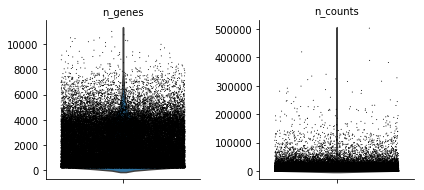

In [162]:
sc.pl.violin(adata, ['n_genes', 'n_counts'],jitter=0.4, multi_panel=True)

/home/ubuntu/maca-data-analysis/scanpy/scanpy/plotting/_anndata.py:318: DeprecationWarning: Use obs_vector instead of _get_obs_array, _get_obs_array will be removed in the future.
  x_arr = adata._get_obs_array(x, use_raw=use_raw, layer=layers[0])
/home/ubuntu/anaconda3/lib/python3.7/site-packages/anndata/core/anndata.py:1469: FutureWarning: In a future version of AnnData, access to `.X` by passing `layer='X'` will be removed. Instead pass `layer=None`.
  FutureWarning
/home/ubuntu/maca-data-analysis/scanpy/scanpy/plotting/_anndata.py:319: DeprecationWarning: Use obs_vector instead of _get_obs_array, _get_obs_array will be removed in the future.
  y_arr = adata._get_obs_array(y, use_raw=use_raw, layer=layers[1])
/home/ubuntu/anaconda3/lib/python3.7/site-packages/anndata/core/anndata.py:1469: FutureWarning: In a future version of AnnData, access to `.X` by passing `layer='X'` will be removed. Instead pass `layer=None`.
  FutureWarning


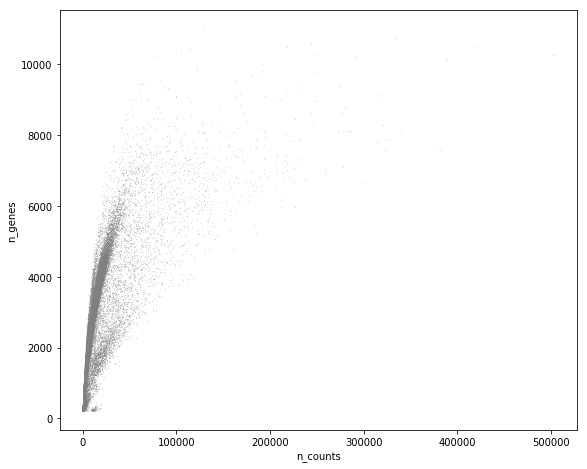

In [163]:
sc.pl.scatter(adata, x='n_counts', y='n_genes')

Because we're doing first exploratory pass let's remove cells that have more than 5000 genes given that those have higher chances of being doublets

In [164]:
adata = adata[adata.obs['n_genes'] < 5000, :]

In [165]:
adata

View of AnnData object with n_obs × n_vars = 62059 × 21380 
    obs: '10X_plate', 'batch', 'tissue', 'method', 'sex', 'subjectid', 'n_genes', 'percent_mito', 'n_counts'
    var: 'n_cells'

Following the standard pipeline, next we normalize, log, compute highly variable genes and scale

In [166]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)

normalizing by total count per cell


Trying to set attribute `.obs` of view, making a copy.


    finished (0:00:01): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


In [167]:
sc.pp.log1p(adata)


In [168]:
adata.raw = adata

In [169]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

extracting highly variable genes
    finished (0:00:02)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


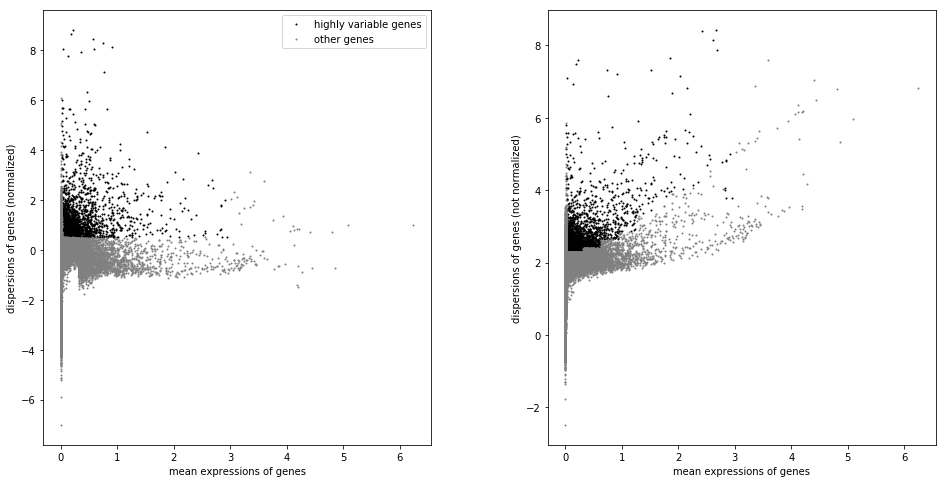

In [170]:
sc.pl.highly_variable_genes(adata)


In [171]:
adata


AnnData object with n_obs × n_vars = 62059 × 21380 
    obs: '10X_plate', 'batch', 'tissue', 'method', 'sex', 'subjectid', 'n_genes', 'percent_mito', 'n_counts'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'

In [172]:
sc.pp.scale(adata, max_value=10)


Next we compute PCA

In [173]:
sc.tl.pca(adata, svd_solver='arpack')


computing PCA with n_comps = 50
computing PCA on highly variable genes
    finished (0:00:05)


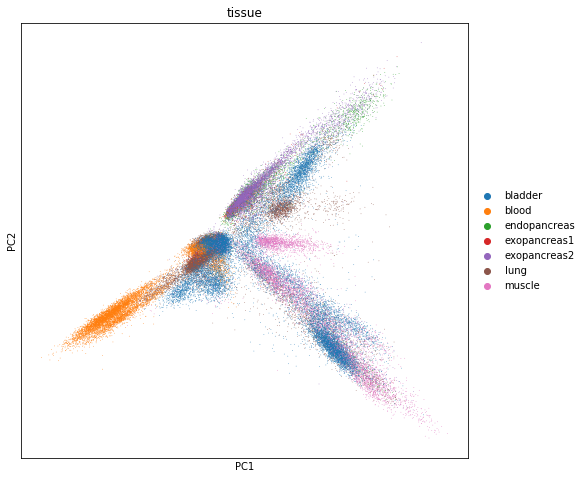

In [174]:
sc.pl.pca(adata, color='tissue')


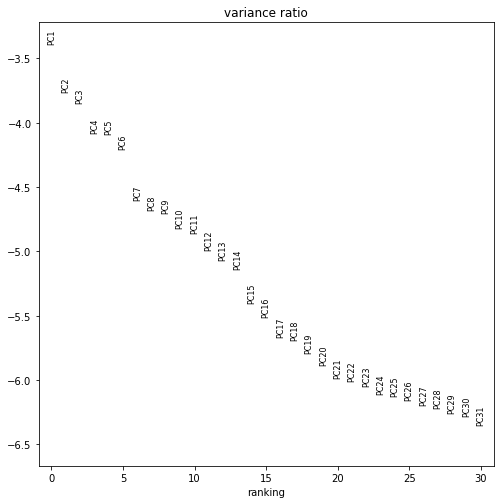

In [175]:
sc.pl.pca_variance_ratio(adata, log=True)


Now we're ready to start fishing out some structure in the data

In [176]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=24)


computing neighbors
    using 'X_pca' with n_pcs = 24
    finished (0:00:10)


In [177]:
sc.tl.umap(adata)


computing UMAP
    finished (0:01:04)


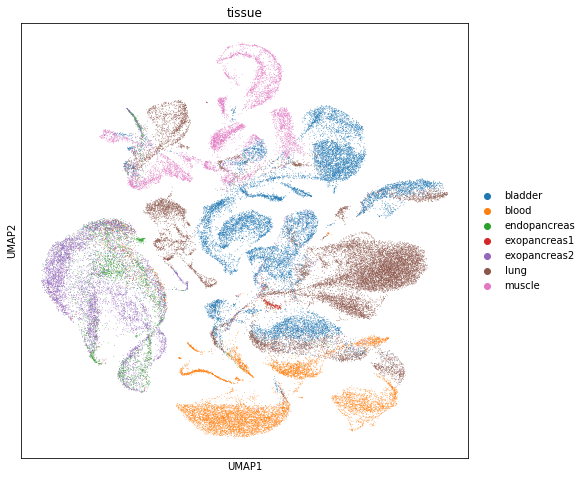

In [178]:
# sc.settings.set_figure_params(dpi=200)
sc.pl.umap(adata, color=['tissue'])

In [179]:
set(adata.obs['tissue'])

{'bladder',
 'blood',
 'endopancreas',
 'exopancreas1',
 'exopancreas2',
 'lung',
 'muscle'}

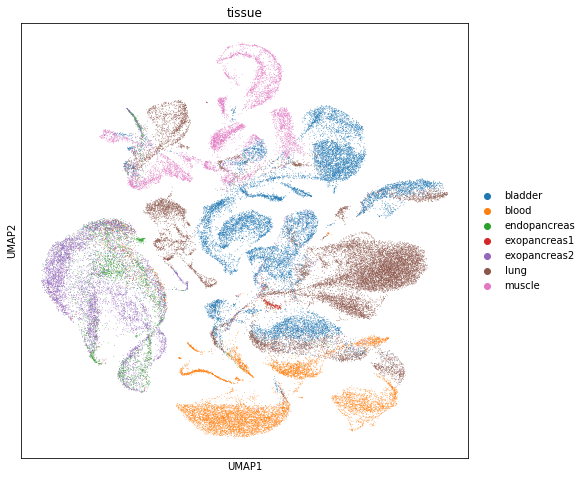

In [180]:
sc.pl.umap(adata, color=['tissue'],use_raw=False)

Let's take a look at one tissue as e.g. for batch effect...

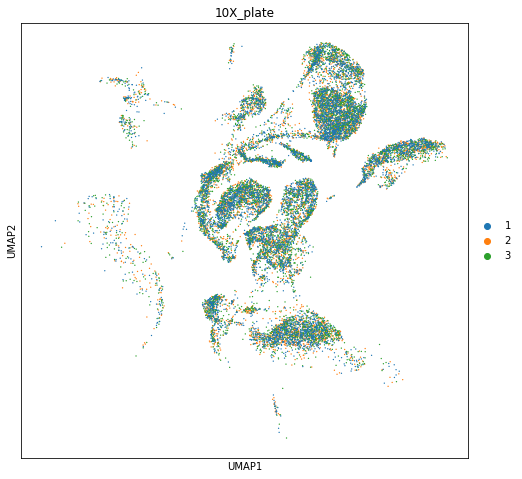

In [181]:
sc.pl.umap(adata[adata.obs['tissue']=='bladder'], color=['10X_plate'])

Looking good! Into clustering...

In [182]:
sc.tl.louvain(adata)

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:08)


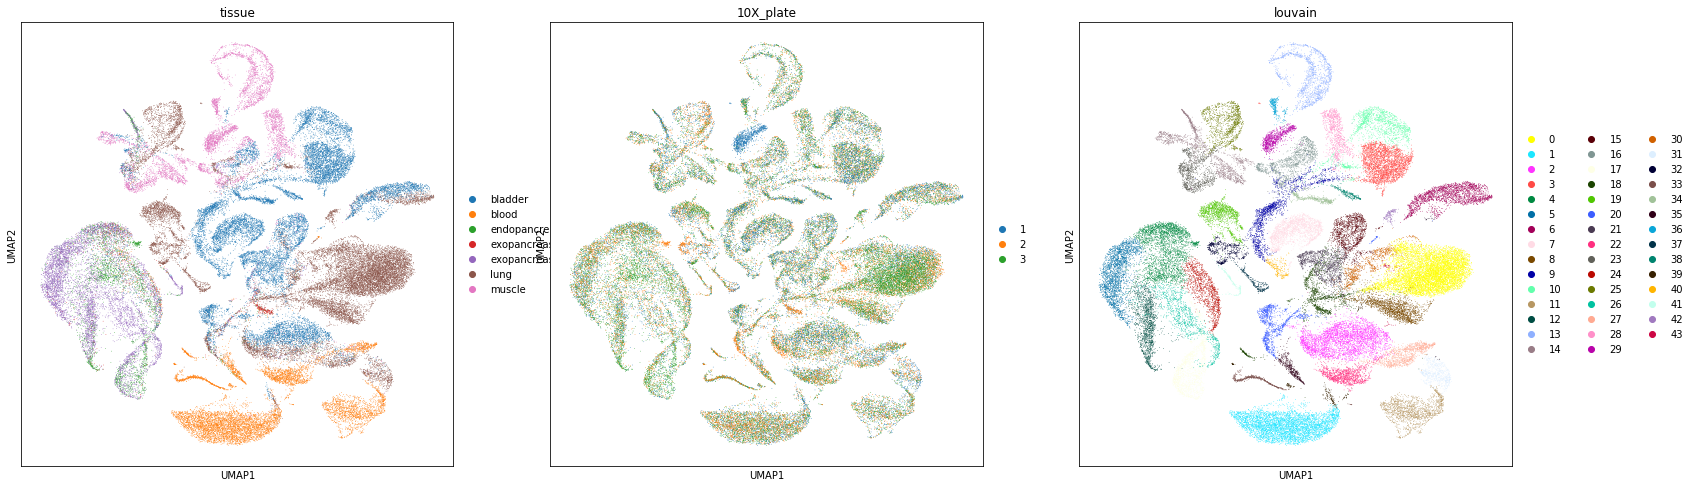

In [183]:
sc.pl.umap(adata, color=['tissue','10X_plate','louvain'])

Using the wilcoxon rank test we can compute the marker genes for each of the 45 global clusters

In [184]:
sc.tl.rank_genes_groups(adata, 'louvain', method='wilcoxon')

ranking genes
    finished (0:03:15)


In [185]:
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [186]:
sapiens_rank_genes = pd.DataFrame(adata.uns['rank_genes_groups']['names'])
sapiens_rank_genes.to_csv('/maca-bulk/sapiens/tabula-sapiens-10X-pilot-filtered-global-rank-genes.csv')
sapiens_rank_genes.head(15)

0         1        2         3        4        5        6         7  \
0     APOC1    S100A8    CXCR4       C1R    PRSS2   SPINK1   TPSAB1     KRT19   
1      FBP1    IFITM2     BTG1     FBLN1    PNLIP     CTRC    TPSB2      GPX2   
2       FTL    S100A9  ZFP36L2     SFRP2    PRSS1     SYCN    HPGDS     FXYD3   
3      ACP5    FCGR3B     IL32       DCN  PLA2G1B     CLPS     CPA3     S100P   
4      C1QA     NAMPT     CD3D       CFD    REG1A   CELA3A    ANXA1     CLDN4   
5      FTH1      MNDA     IL7R       MGP   CELA3A     CPA2      VIM   TACSTD2   
6     VSIG4     NEAT1     RPS3    IGFBP6   CELA2A     CPA1    RPL11      SNCG   
7    CXCL16      SRGN     CD3E       C1S   CELA3B     CPB1    MS4A2  CDC42EP5   
8      CD68     CSF3R  TSC22D3  SERPINF1    CTRB1    CTRB1    RPS4X       SFN   
9     MARCO     LITAF      CD2        C3     CPB1   CELA3B  RPL36AL      PERP   
10     MSR1     BASP1  PTPRCAP       GSN    AMY2A    PNLIP     PTMA      KLF5   
11     CTSD     PTPRC    ARL4C    CCDC80    CTRB2  PLA2G1B    RPL10  MIR205HG   
12  CYP27A1      VNN2      B2M    EFEMP1     CPA1    PRSS1   RPS27A      AGR2   
13    MS4A7    FAM65B   MALAT1     ADH1B     CLPS      CEL      FAU  C19orf33   
14     C1QB  SLC25A37     CCL5    COL1A2     CTRC    PRSS2     SRGN      AQP3   

          8         9    ...           34       35        36      37     38  \
0    MALAT1  MTRNR2L8    ...        NEAT1    CD79A   SPARCL1  LRRIQ1  ACTG2   
1      XIST       CFD    ...       MALAT1     CD37      DLK1    CAPS   MYLK   
2   SLC11A1     KRT19    ...        MYH11    CD79B    IGFBP5   EFHC1  MYH11   
3   RNA45S5     DHRS2    ...        CALD1    MS4A1  HSP90AB1     RP1   CNN1   
4     NEAT1  MTRNR2L2    ...         SYNM    RPS27    CXCL14   CDHR3   MYL9   
5     INHBA       DCN    ...         XIST    RPS29      MEG3   RSPH1  TAGLN   
6      TFRC     KRT13    ...       AKAP12  PTPRCAP     GPM6B  DNAH12  ACTA2   
7      APOE       MGP    ...       COL6A2   RPL18A    CHRNA1  CEP126    CKB   
8      CTSD     S100P    ...       SYNPO2    RPL39     CRYAB  DNAAF1  CSRP1   
9     MS4A7     RPL13    ...          DES    RPL37   SPATS2L   DNAH5   SMTN   
10     MRC1      RPS6    ...        ITGA5    RPS23      CNN3  CCDC17  CALD1   
11     KLF6     RPS18    ...        THBS1    RPLP2    TUBB2B  CCDC78  PALLD   
12     OLR1     CLDN4    ...        LMCD1    RPS21      NFIA   TPPP3   DSTN   
13  LRRFIP1    S100A6    ...       COL6A1    RPL41      MT1X  ERICH3    DES   
14     ACP5     FBLN1    ...     MTRNR2L8    RPS10    CDKN1C   MS4A8  LMOD1   

         39        40       41       42        43  
0    S100A8     DHRS2   PCSK1N    TPSB2      MSR1  
1    IFITM2     CLDN4      TTR   TPSAB1      CCL5  
2    S100A9  MTRNR2L8      INS    MS4A2      OLR1  
3      SRGN   RNA28S5     SCG5     CPA3      MRC1  
4     NAMPT     KRT19  SLC30A8    HPGDS      CTSD  
5     BASP1     MAST4     GNAS    GATA2     MARCO  
6      ACTB     NEAT1     CHGA    APOC1     MS4A7  
7     LITAF       EZR    ERO1B      FTL      C1QA  
8     NEAT1       SFN      CPE   LGALS3   SLC11A1  
9      MNDA      XIST     SCG3     FTH1     INHBA  
10     RGS2   TACSTD2     PAX6     FBP1  HLA-DQB1  
11   FAM65B     PVRL4  NEUROD1      KIT      ACP5  
12   FCGR3B    FER1L4    ABCC8     CSTB      APOE  
13     LCP1   RNA45S5    PTPRN  ATP6V1F     VSIG4  
14  S100A11     ACTN4  CAMK2N1    VWA5A     APOC1  

[15 rows x 44 columns]

In [187]:
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
sapiens_rank_genes_scores = pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'scores','pvals']})
sapiens_rank_genes_scores.to_csv('/maca-bulk/sapiens/tabula-sapiens-10X-pilot-filtered-global-rank-genes-scores.csv')
sapiens_rank_genes_scores.head(25)

0_n         0_s  0_p       1_n         1_s  1_p      2_n        2_s  \
0      APOC1  139.015518  0.0    S100A8  110.847000  0.0    CXCR4  83.719353   
1       FBP1  138.529602  0.0    IFITM2  110.479958  0.0     BTG1  80.932381   
2        FTL  138.146164  0.0    S100A9  109.315346  0.0  ZFP36L2  75.254623   
3       ACP5  135.116791  0.0    FCGR3B  105.979591  0.0     IL32  68.100922   
4       C1QA  133.794952  0.0     NAMPT  104.671654  0.0     CD3D  67.760506   
5       FTH1  133.230057  0.0      MNDA  103.006859  0.0     IL7R  67.673752   
6      VSIG4  133.101837  0.0     NEAT1  101.196548  0.0     RPS3  63.084156   
7     CXCL16  133.020905  0.0      SRGN  100.420906  0.0     CD3E  62.438255   
8       CD68  133.017517  0.0     CSF3R  100.313530  0.0  TSC22D3  62.214630   
9      MARCO  132.499451  0.0     LITAF   98.595299  0.0      CD2  61.856594   
10      MSR1  132.337631  0.0     BASP1   97.483879  0.0  PTPRCAP  61.552338   
11      CTSD  131.969040  0.0     PTPRC   89.918106  0.0    ARL4C  61.511002   
12   CYP27A1  131.882294  0.0      VNN2   88.862541  0.0      B2M  61.385277   
13     MS4A7  131.741486  0.0    FAM65B   88.574089  0.0   MALAT1  61.038837   
14      C1QB  131.639191  0.0  SLC25A37   88.139793  0.0     CCL5  59.509712   
15      APOE  131.554611  0.0      FPR1   87.180779  0.0     CD48  58.217834   
16     GCHFR  131.371536  0.0       GCA   86.893196  0.0     CD69  57.594288   
17   HLA-DRA  130.707764  0.0      ACTB   84.851059  0.0   RPS27A  57.380287   
18     IFI30  129.858322  0.0      LST1   84.472527  0.0    RPL13  57.308109   
19  HLA-DQB1  129.480560  0.0     CXCR2   84.186600  0.0    RPS19  55.295147   
20    LGALS3  129.331329  0.0   S100A12   78.773193  0.0    RPS12  54.960949   
21      CAPG  129.037308  0.0  SERPINA1   77.794701  0.0   RPL23A  54.813046   
22      MRC1  128.614182  0.0   FAM129A   77.250183  0.0    RPL28  54.538536   
23     LTA4H  128.289795  0.0   S100A11   77.207970  0.0   RPS15A  54.343388   
24      CSTB  128.070297  0.0     CMTM2   76.712959  0.0    RPL10  54.177216   

    2_p       3_n      ...                40_p     41_n       41_s  \
0   0.0       C1R      ...       1.902867e-130   PCSK1N  22.139700   
1   0.0     FBLN1      ...       1.579876e-119      TTR  22.087887   
2   0.0     SFRP2      ...       5.208743e-118      INS  21.484825   
3   0.0       DCN      ...       1.011971e-117     SCG5  19.854303   
4   0.0       CFD      ...       1.552138e-117  SLC30A8  19.803349   
5   0.0       MGP      ...       4.916768e-115     GNAS  19.625027   
6   0.0    IGFBP6      ...       2.771237e-114     CHGA  19.271509   
7   0.0       C1S      ...       1.081303e-109    ERO1B  19.198854   
8   0.0  SERPINF1      ...       2.832252e-107      CPE  18.602165   
9   0.0        C3      ...       5.315739e-103     SCG3  18.496824   
10  0.0       GSN      ...       2.008589e-102     PAX6  17.980398   
11  0.0    CCDC80      ...       1.023114e-101  NEUROD1  17.856167   
12  0.0    EFEMP1      ...        1.735049e-98    ABCC8  17.428553   
13  0.0     ADH1B      ...        7.166710e-96    PTPRN  17.318207   
14  0.0    COL1A2      ...        9.268514e-95  CAMK2N1  16.949757   
15  0.0     HTRA1      ...        2.660370e-93     GAD2  16.945726   
16  0.0       LUM      ...        1.951176e-90     BEX1  16.724070   
17  0.0      CTSK      ...        1.487837e-86  PPP1R1A  16.607098   
18  0.0    COL6A2      ...        8.186938e-86     CHGB  16.523785   
19  0.0     AEBP1      ...        5.553120e-83     SCG2  15.893750   
20  0.0     PRELP      ...        4.178339e-82    PCSK2  15.709138   
21  0.0    CYBRD1      ...        4.852267e-82     SCGN  15.619746   
22  0.0     MFAP4      ...        1.715081e-81     IAPP  15.202103   
23  0.0      NNMT      ...        6.572200e-81   KCNK16  14.468324   
24  0.0      GPX3      ...        3.989808e-79    NPDC1  14.451946   

             41_p      42_n       42_s          42_p      43_n       43_s  \
0   1.311076e-108     TPSB2  2

Let's look at the overall cycling distribution just for curiosity

In [188]:
# cell cycle distribution -- using Tirosh et al',' Science 2015
g1s_genes =  ['MCM5','PCNA','TYMS','FEN1','MCM2','MCM4','RRM1','UNG','GINS2','MCM6','CDCA7','DTL','PRIM1','UHRF1','MLF1IP','HELLS','RFC2','RPA2','NASP',
         'RAD51AP1','GMNN','WDR76','SLBP','CCNE2','UBR7','POLD3','MSH2','ATAD2','RAD51','RRM2','CDC45','CDC6','EXO1','TIPIN','DSCC1','BLM','CASP8AP2',
         'USP1','CLSPN','POLA1','CHAF1B','BRIP1','E2F8']

g2m_genes = ['HMGB2','CDK1','NUSAP1','UBE2C','BIRC5','TPX2','TOP2A','NDC80','CKS2','NUF2','CKS1B','MKI67','TMPO','CENPF','TACC3','FAM64A','SMC4','CCNB2',
        'CKAP2L','CKAP2','AURKB','BUB1','KIF11','ANP32E','TUBB4B','GTSE1','KIF20B','HJURP','HJURP','CDCA3','HN1','CDC20','TTK','CDC25C','KIF2C',
        'RANGAP1','NCAPD2','DLGAP5','CDCA2','CDCA8','ECT2','KIF23','HMMR','AURKA','PSRC1','ANLN','LBR','CKAP5','CENPE','CTCF','NEK2','G2E3','GAS2L3',
        'CBX5','CENPA']


In [189]:
sc.tl.score_genes_cell_cycle(adata, s_genes=g1s_genes, g2m_genes=g2m_genes)


calculating cell cycle phase
computing score 'S_score'
    finished (0:00:11)
computing score 'G2M_score'
    finished (0:00:11)
-->     'phase', cell cycle phase (adata.obs)


In [190]:
adata

AnnData object with n_obs × n_vars = 62059 × 21380 
    obs: '10X_plate', 'batch', 'tissue', 'method', 'sex', 'subjectid', 'n_genes', 'percent_mito', 'n_counts', 'louvain', 'S_score', 'G2M_score', 'phase'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'pca', 'tissue_colors', 'neighbors', 'louvain', '10X_plate_colors', 'louvain_colors', 'rank_genes_groups'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'

... storing 'phase' as categorical


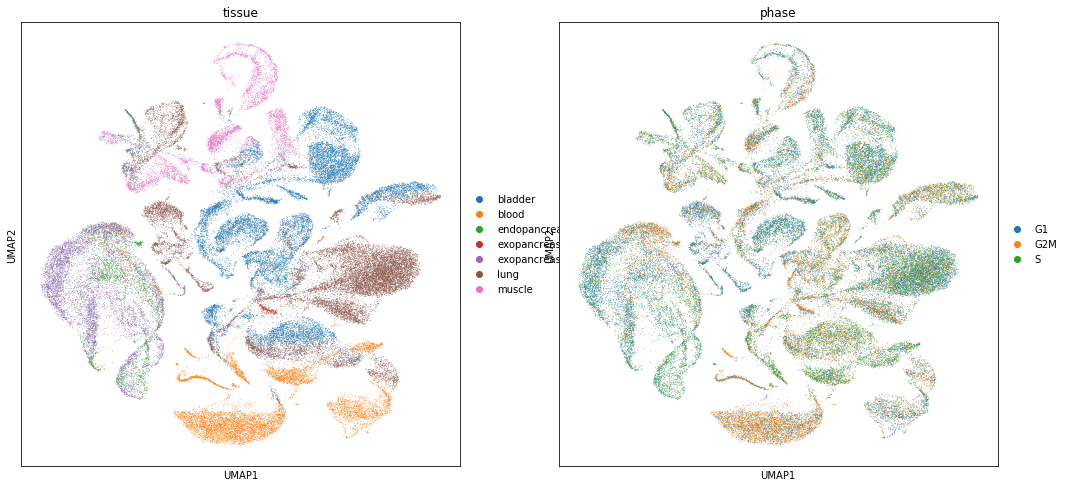

In [191]:
sc.pl.umap(adata,color=['tissue','phase'])

Next we will look at the overall tissue compartments

In [192]:
# add tissue compartments -- to be added
epithelial_markers = []
stromal_markers = []
immune_markers = []
endothelial_markera = []

# Split the tissues

In [195]:
adata.obs.groupby(['tissue','10X_plate'])['subjectid'].agg({'ncells pilot':len})#.to_csv('/maca-bulk/sapiens/ncell_pilot.csv')




/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """Entry point for launching an IPython kernel.


ncells pilot
tissue       10X_plate              
bladder      1                  5911
             2                  5505
             3                  5408
blood        1                  2943
             2                  3035
             3                  3195
endopancreas 1                   417
             2                   318
             3                  2529
exopancreas1 1                   115
             2                   241
             3                   118
exopancreas2 1                  2136
             2                  2268
             3                  2385
lung         1                  5149
             2                  7286
             3                  6928
muscle       1                  2452
             2                  1728
             3                  1992

In [196]:
adata = read_h5ad('/maca-bulk/sapiens/tabula-sapiens-10X-pilot-filtered.h5ad')
print('tissue','total number of cells')
for t in list(set(adata.obs['tissue'])):
    tiss = adata[adata.obs['tissue']==t]
    print(t,len(tiss))
    tiss.write('/maca-bulk/sapiens/tabula-sapiens-10X-pilot-filtered-'+t+'.h5ad')
    

tissue total number of cells
muscle 6230
bladder 17469
endopancreas 3308
blood 9283
lung 19684
exopancreas2 7804
exopancreas1 589


Analyse each tissue individually

Now looking at muscle !!!
make sure data is consistent...
filtered out 1 cells that haveless than 200 genes expressed
filtered out 3647 genes that are detectedin less than 3 cells
get global view of the tissue


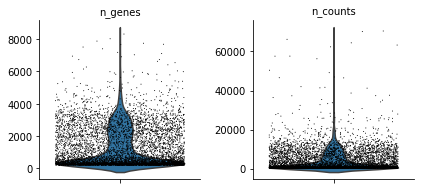

/home/ubuntu/maca-data-analysis/scanpy/scanpy/plotting/_anndata.py:318: DeprecationWarning: Use obs_vector instead of _get_obs_array, _get_obs_array will be removed in the future.
  x_arr = adata._get_obs_array(x, use_raw=use_raw, layer=layers[0])
/home/ubuntu/anaconda3/lib/python3.7/site-packages/anndata/core/anndata.py:1469: FutureWarning: In a future version of AnnData, access to `.X` by passing `layer='X'` will be removed. Instead pass `layer=None`.
  FutureWarning
/home/ubuntu/maca-data-analysis/scanpy/scanpy/plotting/_anndata.py:319: DeprecationWarning: Use obs_vector instead of _get_obs_array, _get_obs_array will be removed in the future.
  y_arr = adata._get_obs_array(y, use_raw=use_raw, layer=layers[1])
/home/ubuntu/anaconda3/lib/python3.7/site-packages/anndata/core/anndata.py:1469: FutureWarning: In a future version of AnnData, access to `.X` by passing `layer='X'` will be removed. Instead pass `layer=None`.
  FutureWarning


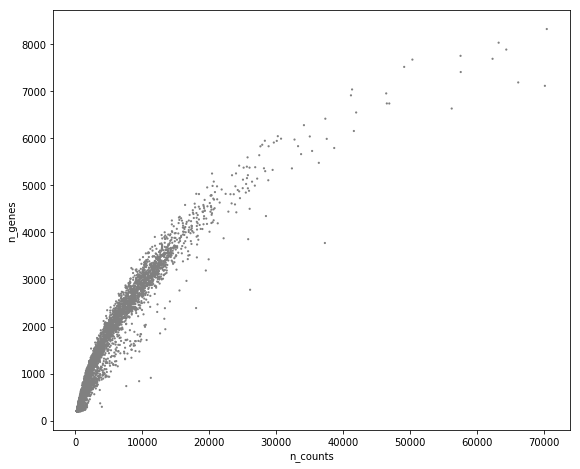

repeat the basic pre-processing
normalizing by total count per cell


Trying to set attribute `.obs` of view, making a copy.


    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
PCA
computing PCA with n_comps = 50
computing PCA on highly variable genes
    finished (0:00:00)


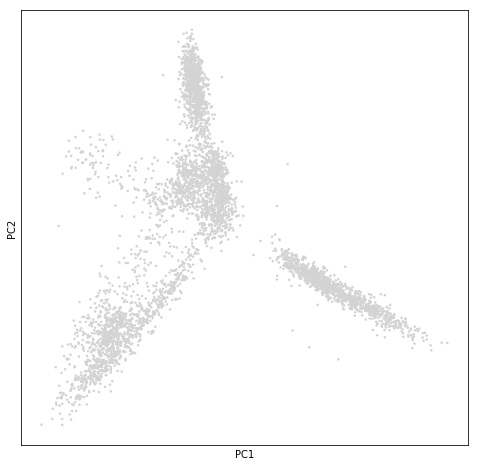

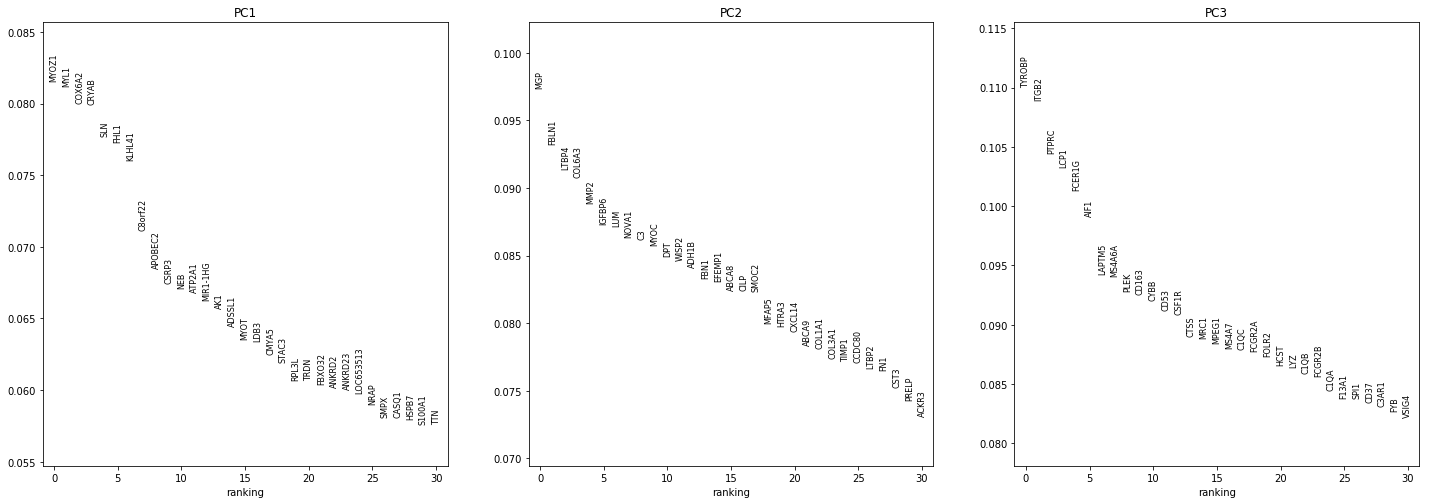

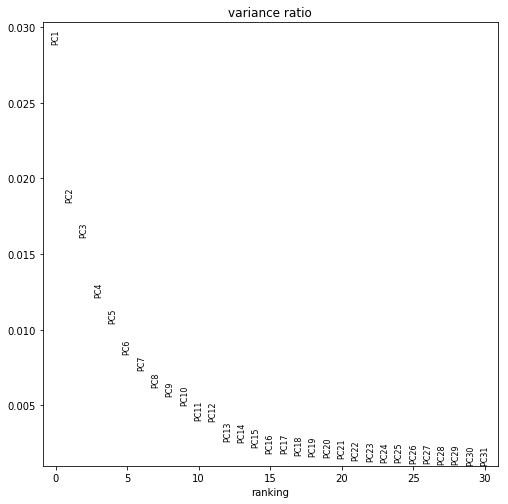

neighbors
computing neighbors
    using 'X_pca' with n_pcs = 10
    finished (0:00:02)
visualizations
computing UMAP
    finished (0:00:09)
computing tSNE
    using 'X_pca' with n_pcs = 50
    using the 'MulticoreTSNE' package by Ulyanov (2017)
    finished (0:00:33)
doing Louvain clustering for quick overview but likely to change this into Leiden
running Louvain clustering


In [ ]:
for t in list(set(adata.obs['tissue']))[0:2]:
    print('Now looking at ' +t+ '!!!')
    adata = read_h5ad('/maca-bulk/sapiens/tabula-sapiens-10X-pilot-filtered-'+t+'.h5ad')
    
    print('make sure data is consistent...')
    sc.pp.filter_cells(adata, min_genes=200)
    sc.pp.filter_genes(adata, min_cells=3)
    
    print('get global view of the tissue')
    adata.obs['n_counts'] = adata.X.sum(axis=1).A1
    
    sc.pl.violin(adata, ['n_genes', 'n_counts'],
             jitter=0.4, multi_panel=True)
    sc.pl.scatter(adata, x='n_counts', y='n_genes')
    
    print('repeat the basic pre-processing')
    adata = adata[adata.obs['n_genes'] < 5000, :]
    adata = adata[adata.obs['n_counts'] > 500, :]
    
    sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
    sc.pp.log1p(adata)
    
    adata.raw = adata
    sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
    sc.pp.scale(adata, max_value=10)
    
    print('PCA')
    sc.tl.pca(adata, svd_solver='arpack')
    sc.pl.pca_overview(adata)
    
    print('neighbors')
    sc.pp.neighbors(adata, n_neighbors=10, n_pcs=10)
    
    print('visualizations')
    sc.tl.umap(adata)
    sc.tl.tsne(adata)
    
    print('doing Louvain clustering for quick overview but likely to change this into Leiden')
    sc.tl.louvain(adata,resolution=.5)
    
    print('plot')
    sc.pl.tsne(adata, color=['10X_plate','louvain'],cmap='Oranges',ncols=1)
    sc.pl.umap(adata, color=['10X_plate','louvain'],cmap='Oranges',ncols=1)
    
    print('compute tissue rank genes')
    sc.tl.rank_genes_groups(adata, 'louvain', method='wilcoxon')
    tiss_rank_genes = pd.DataFrame(adata.uns['rank_genes_groups']['names'])
    tiss_rank_genes.to_csv('/maca-bulk/sapiens/tabula-sapiens-10X-pilot-filtered-'+t+'-rank-genes.csv')
    
    result = adata.uns['rank_genes_groups']
    groups = result['names'].dtype.names
    tiss_rank_genes_score = pd.DataFrame(
        {group + '_' + key[:1]: result[key][group]
        for group in groups for key in ['names', 'scores','pvals']})
    tiss_rank_genes_score.to_csv('/maca-bulk/sapiens/tabula-sapiens-10X-pilot-filtered-'+t+'-rank-genes-score.csv')
    tiss_rank_genes.head(25)



    

# Bladder

In [124]:
t = 'bladder'

In [125]:
adata = read_h5ad('/maca-bulk/sapiens/tabula-sapiens-10X-pilot-filtered-'+t+'.h5ad')
adata

AnnData object with n_obs × n_vars = 17469 × 21380 
    obs: '10X_plate', 'batch', 'tissue', 'method', 'sex', 'subjectid', 'n_genes'
    var: 'n_cells'

In [126]:
adata.obs.columns

Index(['10X_plate', 'batch', 'tissue', 'method', 'sex', 'subjectid',
       'n_genes'],
      dtype='object')

In [127]:
adata = adata[adata.obs['tissue']=='bladder']
adata

View of AnnData object with n_obs × n_vars = 17469 × 21380 
    obs: '10X_plate', 'batch', 'tissue', 'method', 'sex', 'subjectid', 'n_genes'
    var: 'n_cells'

In [128]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

Trying to set attribute `.obs` of view, making a copy.


filtered out 1645 genes that are detectedin less than 3 cells


In [129]:
adata

AnnData object with n_obs × n_vars = 17469 × 19735 
    obs: '10X_plate', 'batch', 'tissue', 'method', 'sex', 'subjectid', 'n_genes'
    var: 'n_cells'

In [130]:
adata.obs['n_counts'] = adata.X.sum(axis=1).A1

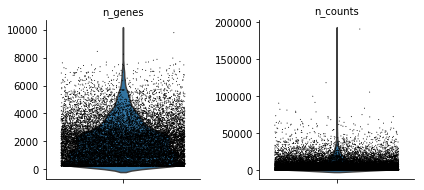

In [131]:
sc.pl.violin(adata, ['n_genes', 'n_counts'],
             jitter=0.4, multi_panel=True)

/home/ubuntu/maca-data-analysis/scanpy/scanpy/plotting/_anndata.py:318: DeprecationWarning: Use obs_vector instead of _get_obs_array, _get_obs_array will be removed in the future.
  x_arr = adata._get_obs_array(x, use_raw=use_raw, layer=layers[0])
/home/ubuntu/anaconda3/lib/python3.7/site-packages/anndata/core/anndata.py:1469: FutureWarning: In a future version of AnnData, access to `.X` by passing `layer='X'` will be removed. Instead pass `layer=None`.
  FutureWarning
/home/ubuntu/maca-data-analysis/scanpy/scanpy/plotting/_anndata.py:319: DeprecationWarning: Use obs_vector instead of _get_obs_array, _get_obs_array will be removed in the future.
  y_arr = adata._get_obs_array(y, use_raw=use_raw, layer=layers[1])
/home/ubuntu/anaconda3/lib/python3.7/site-packages/anndata/core/anndata.py:1469: FutureWarning: In a future version of AnnData, access to `.X` by passing `layer='X'` will be removed. Instead pass `layer=None`.
  FutureWarning


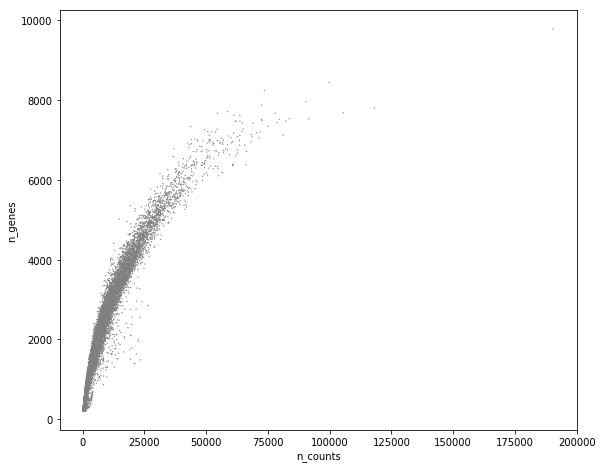

In [132]:
sc.pl.scatter(adata, x='n_counts', y='n_genes')

In [133]:
adata = adata[adata.obs['n_genes'] < 5000, :]
adata

View of AnnData object with n_obs × n_vars = 16824 × 19735 
    obs: '10X_plate', 'batch', 'tissue', 'method', 'sex', 'subjectid', 'n_genes', 'n_counts'
    var: 'n_cells'

/home/ubuntu/maca-data-analysis/scanpy/scanpy/plotting/_anndata.py:318: DeprecationWarning: Use obs_vector instead of _get_obs_array, _get_obs_array will be removed in the future.
  x_arr = adata._get_obs_array(x, use_raw=use_raw, layer=layers[0])
/home/ubuntu/anaconda3/lib/python3.7/site-packages/anndata/core/anndata.py:1469: FutureWarning: In a future version of AnnData, access to `.X` by passing `layer='X'` will be removed. Instead pass `layer=None`.
  FutureWarning
/home/ubuntu/maca-data-analysis/scanpy/scanpy/plotting/_anndata.py:319: DeprecationWarning: Use obs_vector instead of _get_obs_array, _get_obs_array will be removed in the future.
  y_arr = adata._get_obs_array(y, use_raw=use_raw, layer=layers[1])
/home/ubuntu/anaconda3/lib/python3.7/site-packages/anndata/core/anndata.py:1469: FutureWarning: In a future version of AnnData, access to `.X` by passing `layer='X'` will be removed. Instead pass `layer=None`.
  FutureWarning


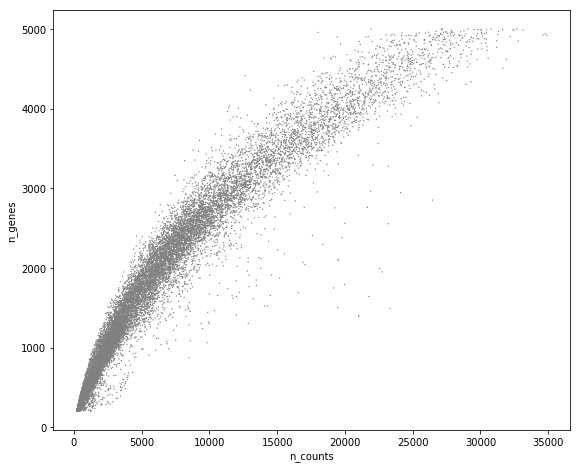

In [134]:
sc.pl.scatter(adata, x='n_counts', y='n_genes')

In [135]:
adata = adata[adata.obs['n_counts'] > 500, :]
adata

View of AnnData object with n_obs × n_vars = 15444 × 19735 
    obs: '10X_plate', 'batch', 'tissue', 'method', 'sex', 'subjectid', 'n_genes', 'n_counts'
    var: 'n_cells'

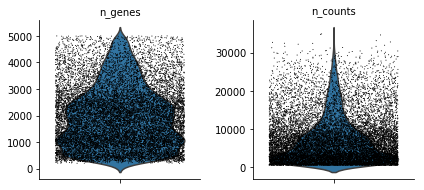

In [136]:
sc.pl.violin(adata, ['n_genes', 'n_counts'],
             jitter=0.4, multi_panel=True)

In [91]:
adata

AnnData object with n_obs × n_vars = 16824 × 19735 
    obs: '10X_plate', 'batch', 'tissue', 'method', 'sex', 'subjectid', 'n_genes', 'n_counts'
    var: 'n_cells'

/home/ubuntu/maca-data-analysis/scanpy/scanpy/plotting/_anndata.py:318: DeprecationWarning: Use obs_vector instead of _get_obs_array, _get_obs_array will be removed in the future.
  x_arr = adata._get_obs_array(x, use_raw=use_raw, layer=layers[0])
/home/ubuntu/anaconda3/lib/python3.7/site-packages/anndata/core/anndata.py:1469: FutureWarning: In a future version of AnnData, access to `.X` by passing `layer='X'` will be removed. Instead pass `layer=None`.
  FutureWarning
/home/ubuntu/maca-data-analysis/scanpy/scanpy/plotting/_anndata.py:319: DeprecationWarning: Use obs_vector instead of _get_obs_array, _get_obs_array will be removed in the future.
  y_arr = adata._get_obs_array(y, use_raw=use_raw, layer=layers[1])
/home/ubuntu/anaconda3/lib/python3.7/site-packages/anndata/core/anndata.py:1469: FutureWarning: In a future version of AnnData, access to `.X` by passing `layer='X'` will be removed. Instead pass `layer=None`.
  FutureWarning


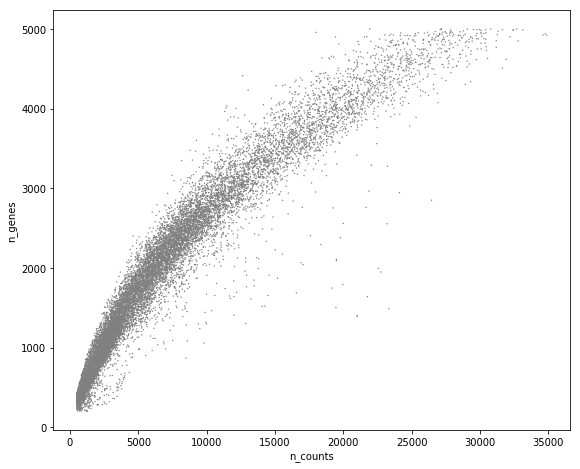

In [137]:
sc.pl.scatter(adata, x='n_counts', y='n_genes')

In [138]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


In [139]:
sc.pp.log1p(adata)

In [140]:
adata.raw = adata

In [141]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)


extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


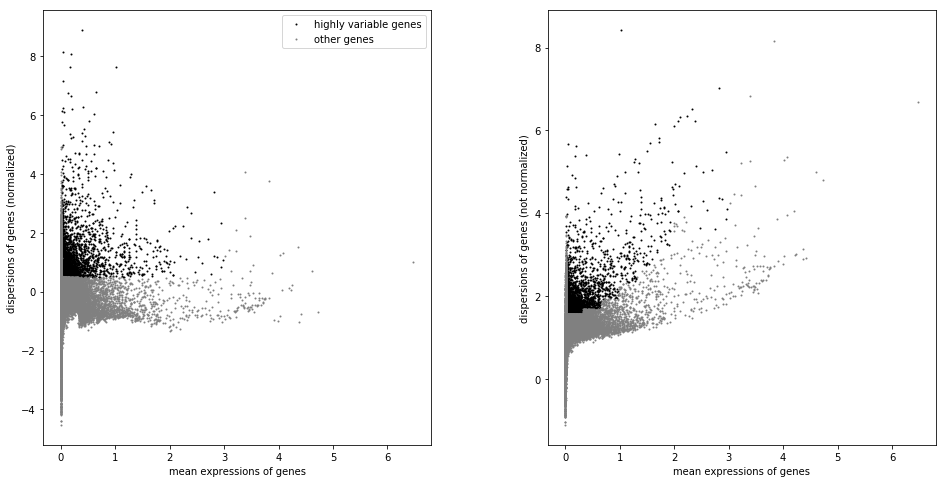

In [142]:
sc.pl.highly_variable_genes(adata)

In [143]:
sc.pp.scale(adata, max_value=10)


In [144]:
sc.tl.pca(adata, svd_solver='arpack')

computing PCA with n_comps = 50
computing PCA on highly variable genes
    finished (0:00:02)


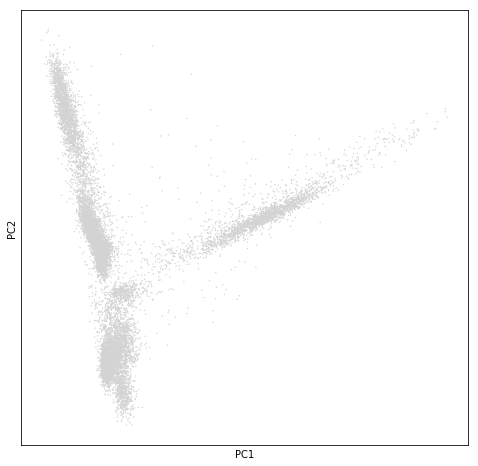

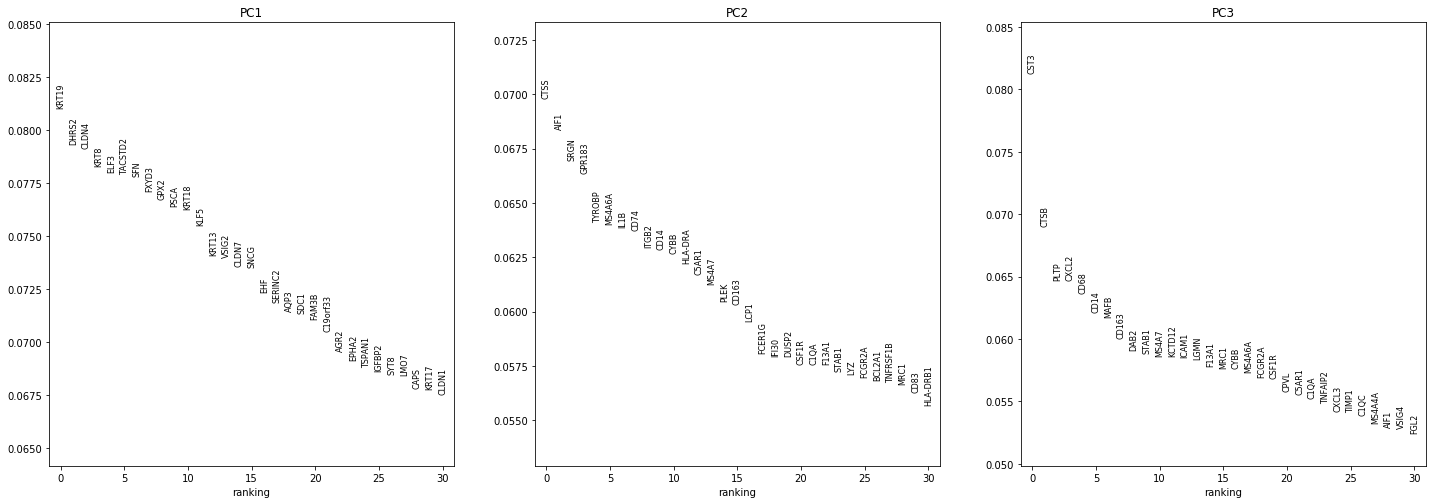

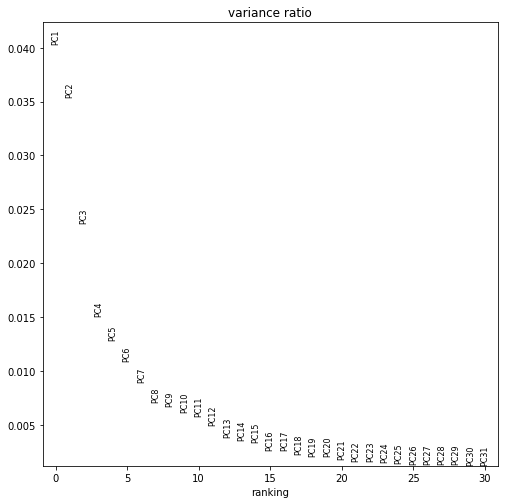

In [145]:
sc.pl.pca_overview(adata)

In [146]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=10)

computing neighbors
    using 'X_pca' with n_pcs = 10
    finished (0:00:02)


In [155]:
sc.tl.umap(adata)
sc.tl.tsne(adata)

computing UMAP
    finished (0:00:14)
computing tSNE
    using 'X_pca' with n_pcs = 50
    using the 'MulticoreTSNE' package by Ulyanov (2017)
    finished (0:02:06)


In [148]:
sc.tl.louvain(adata,resolution=.5)



running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:02)


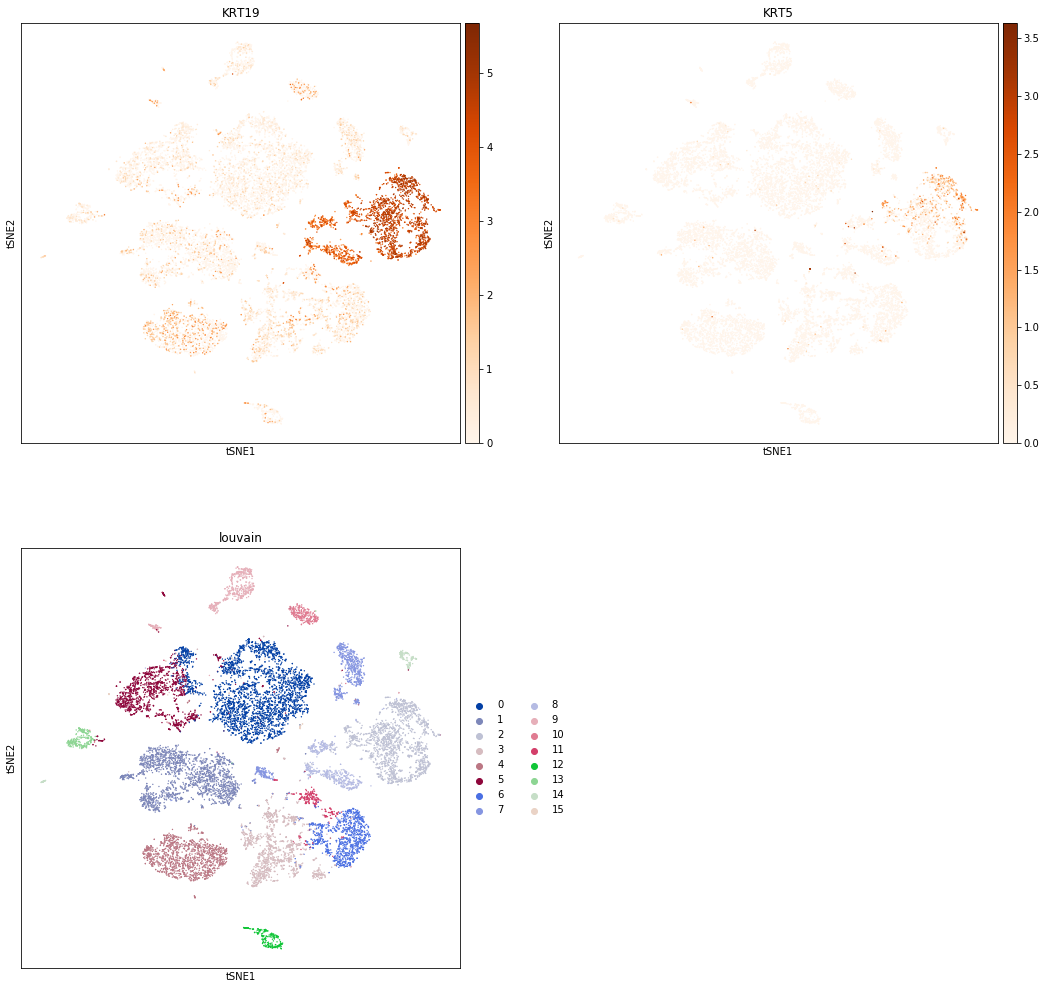

In [156]:
sc.pl.tsne(adata, color=['KRT19','KRT5','louvain'],cmap='Oranges',ncols=2)

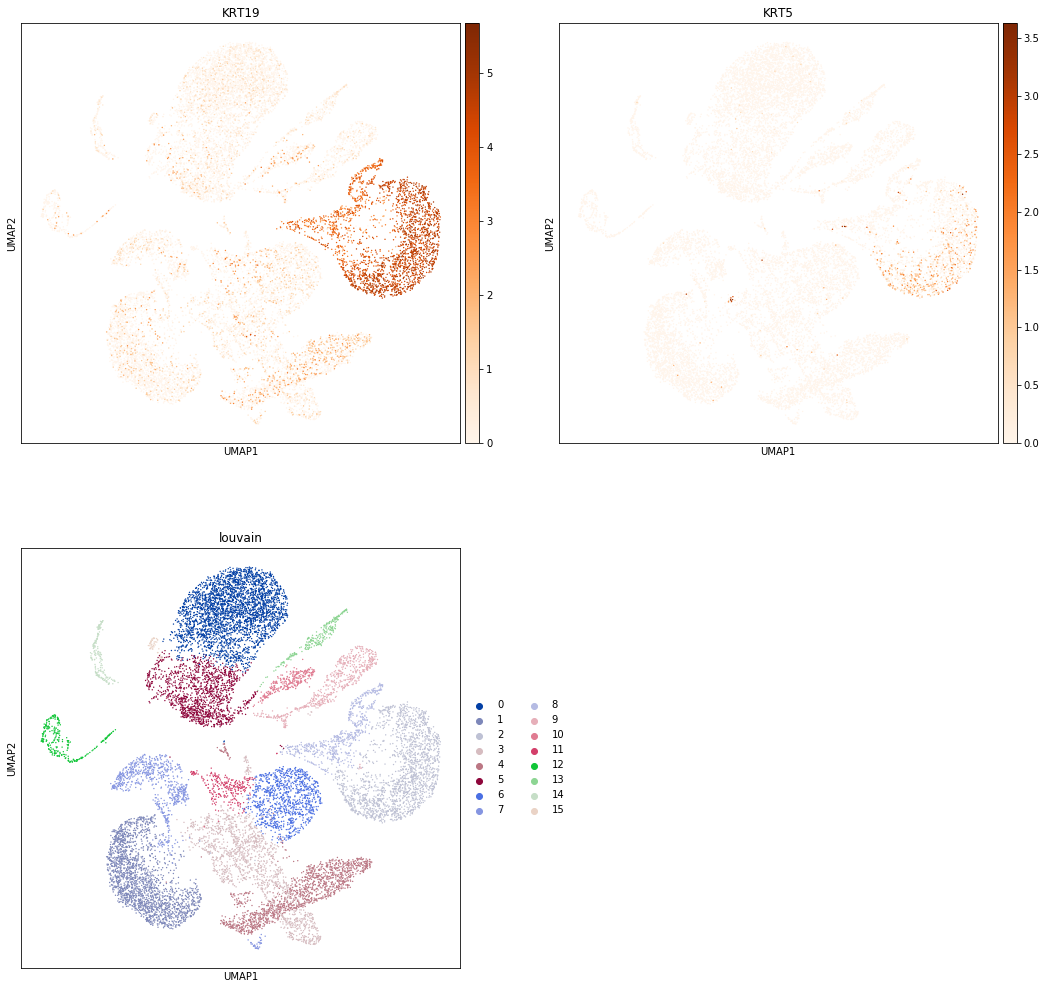

In [151]:
sc.pl.umap(adata, color=['KRT19','KRT5','louvain'],cmap='Oranges',ncols=2)

ranking genes
    finished (0:00:30)


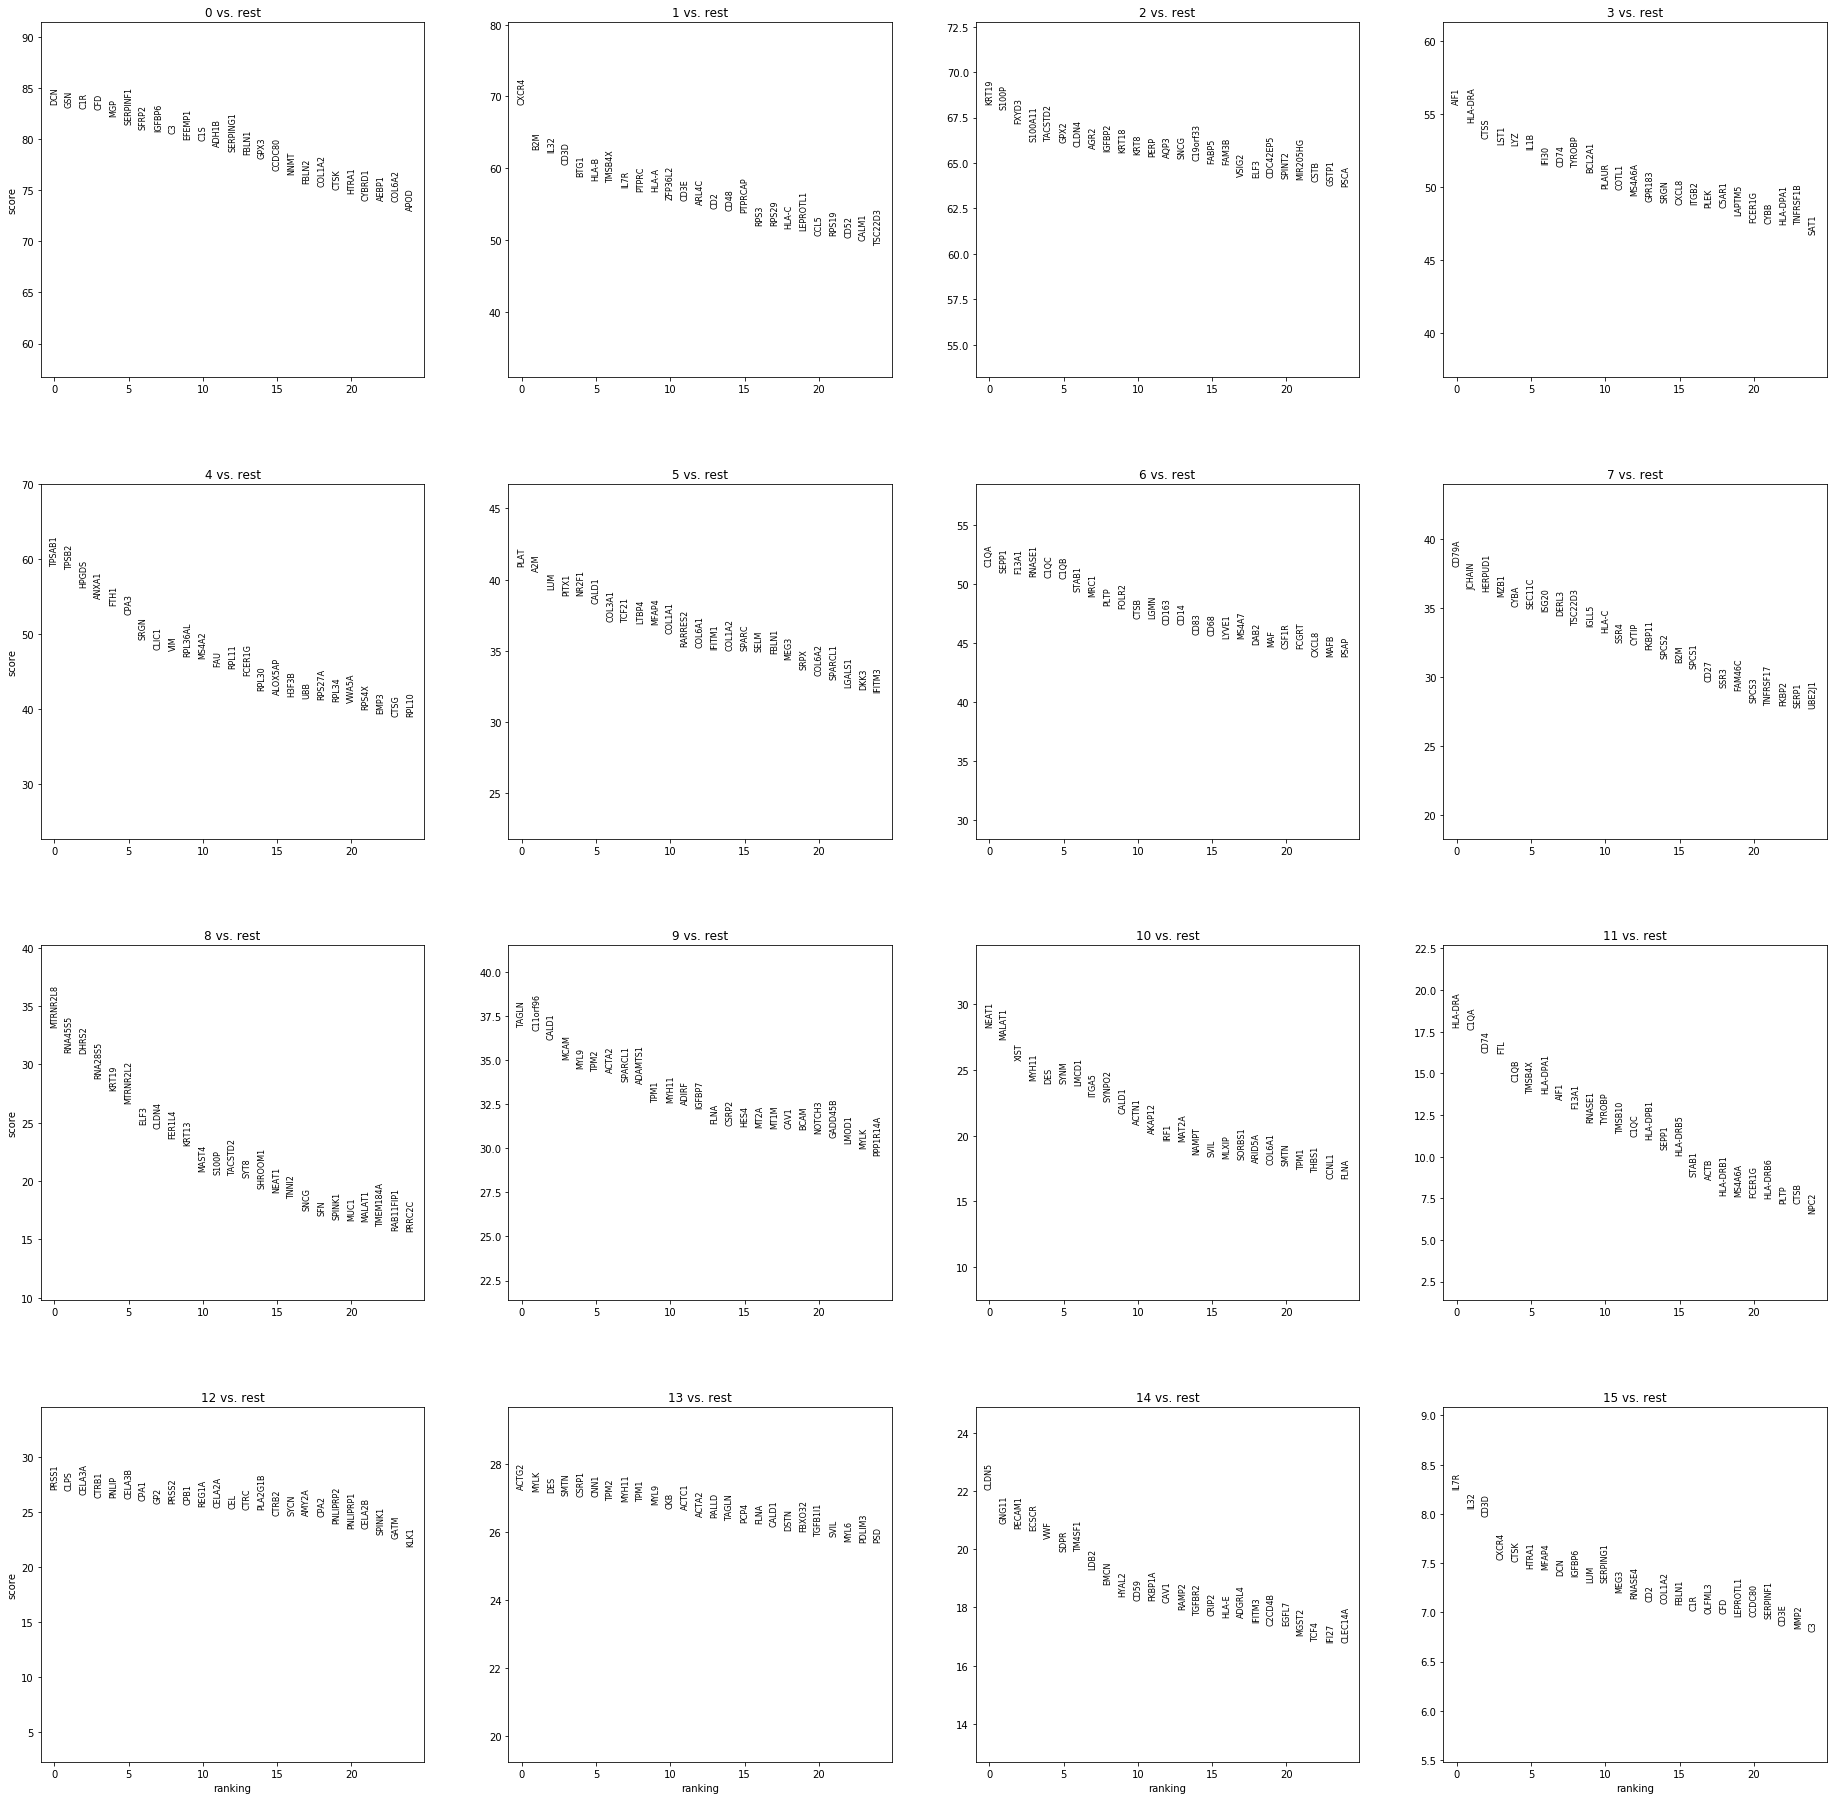

In [152]:
sc.tl.rank_genes_groups(adata, 'louvain', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)


In [153]:
tiss_rank_genes = pd.DataFrame(adata.uns['rank_genes_groups']['names'])
tiss_rank_genes.head(15)

0        1         2        3        4        5       6        7  \
0        DCN    CXCR4     KRT19     AIF1   TPSAB1     PLAT    C1QA    CD79A   
1        GSN      B2M     S100P  HLA-DRA    TPSB2      A2M   SEPP1   JCHAIN   
2        C1R     IL32     FXYD3     CTSS    HPGDS      LUM   F13A1  HERPUD1   
3        CFD     CD3D   S100A11     LST1    ANXA1    PITX1  RNASE1     MZB1   
4        MGP     BTG1   TACSTD2      LYZ     FTH1    NR2F1    C1QC     CYBA   
5   SERPINF1    HLA-B      GPX2     IL1B     CPA3    CALD1    C1QB   SEC11C   
6      SFRP2   TMSB4X     CLDN4    IFI30     SRGN   COL3A1   STAB1    ISG20   
7     IGFBP6     IL7R      AGR2     CD74    CLIC1    TCF21    MRC1    DERL3   
8         C3    PTPRC    IGFBP2   TYROBP      VIM    LTBP4    PLTP  TSC22D3   
9     EFEMP1    HLA-A     KRT18   BCL2A1  RPL36AL    MFAP4   FOLR2    IGLL5   
10       C1S  ZFP36L2      KRT8    PLAUR    MS4A2   COL1A1    CTSB    HLA-C   
11     ADH1B     CD3E      PERP    COTL1      FAU  RARRES2    LGMN     SSR4   
12  SERPING1    ARL4C      AQP3   MS4A6A    RPL11   COL6A1   CD163    CYTIP   
13     FBLN1      CD2      SNCG   GPR183   FCER1G   IFITM1    CD14   FKBP11   
14      GPX3     CD48  C19orf33     SRGN    RPL30   COL1A2    CD83    SPCS2   

           8         9      10        11       12     13      14        15  
0   MTRNR2L8     TAGLN   NEAT1   HLA-DRA    PRSS1  ACTG2   CLDN5      IL7R  
1    RNA45S5  C11orf96  MALAT1      C1QA     CLPS   MYLK   GNG11      IL32  
2      DHRS2     CALD1    XIST      CD74   CELA3A    DES  PECAM1      CD3D  
3    RNA28S5      MCAM   MYH11       FTL    CTRB1   SMTN   ECSCR     CXCR4  
4      KRT19      MYL9     DES      C1QB    PNLIP  CSRP1     VWF      CTSK  
5   MTRNR2L2      TPM2    SYNM    TMSB4X   CELA3B   CNN1    SDPR     HTRA1  
6       ELF3     ACTA2   LMCD1  HLA-DPA1     CPA1   TPM2  TM4SF1     MFAP4  
7      CLDN4   SPARCL1   ITGA5      AIF1      GP2  MYH11    LDB2       DCN  
8     FER1L4   ADAMTS1  SYNPO2     F13A1    PRSS2   TPM1    EMCN    IGFBP6  
9      KRT13      TPM1   CALD1    RNASE1     CPB1   MYL9   HYAL2       LUM  
10     MAST4     MYH11   ACTN1    TYROBP    REG1A    CKB    CD59  SERPING1  
11     S100P     ADIRF  AKAP12    TMSB10   CELA2A  ACTC1  FKBP1A      MEG3  
12   TACSTD2    IGFBP7    IRF1      C1QC      CEL  ACTA2    CAV1    RNASE4  
13      SYT8      FLNA   MAT2A  HLA-DPB1     CTRC  PALLD   RAMP2       CD2  
14   SHROOM1     CSRP2   NAMPT     SEPP1  PLA2G1B  TAGLN  TGFBR2    COL1A2

In [154]:
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'scores','pvals']}).head(25)

0_n        0_s  0_p       1_n        1_s  1_p       2_n        2_s  \
0        DCN  83.396614  0.0     CXCR4  68.916992  0.0     KRT19  68.232338   
1        GSN  83.162827  0.0       B2M  62.660915  0.0     S100P  67.973114   
2        C1R  83.021675  0.0      IL32  62.234589  0.0     FXYD3  67.180351   
3        CFD  82.942062  0.0      CD3D  60.587372  0.0   S100A11  66.209923   
4        MGP  82.214302  0.0      BTG1  58.891117  0.0   TACSTD2  66.192673   
5   SERPINF1  81.499977  0.0     HLA-B  58.417278  0.0      GPX2  66.171097   
6      SFRP2  80.971230  0.0    TMSB4X  58.099461  0.0     CLDN4  65.904076   
7     IGFBP6  80.800941  0.0      IL7R  57.376511  0.0      AGR2  65.822090   
8         C3  80.591515  0.0     PTPRC  56.884701  0.0    IGFBP2  65.630188   
9     EFEMP1  79.979103  0.0     HLA-A  56.797478  0.0     KRT18  65.612572   
10       C1S  79.888847  0.0   ZFP36L2  55.747120  0.0      KRT8  65.496933   
11     ADH1B  79.345337  0.0      CD3E  55.600594  0.0      PERP  65.367287   
12  SERPING1  78.830482  0.0     ARL4C  54.955040  0.0      AQP3  65.301750   
13     FBLN1  78.508957  0.0       CD2  54.447475  0.0      SNCG  65.256683   
14      GPX3  78.138138  0.0      CD48  54.129642  0.0  C19orf33  65.152229   
15    CCDC80  76.950912  0.0   PTPRCAP  53.856262  0.0     FABP5  64.986687   
16      NNMT  76.539490  0.0      RPS3  52.075642  0.0     FAM3B  64.951591   
17     FBLN2  75.707436  0.0     RPS29  52.045750  0.0     VSIG2  64.252953   
18    COL1A2  75.423721  0.0     HLA-C  51.647026  0.0      ELF3  64.217949   
19      CTSK  75.077576  0.0  LEPROTL1  51.412445  0.0  CDC42EP5  64.205582   
20     HTRA1  74.671967  0.0      CCL5  50.725182  0.0    SPINT2  64.149734   
21    CYBRD1  74.053787  0.0     RPS19  50.654613  0.0  MIR205HG  64.099274   
22     AEBP1  73.980522  0.0      CD52  50.476807  0.0      CSTB  64.015465   
23    COL6A2  73.901276  0.0     CALM1  50.051994  0.0     GSTP1  63.787346   
24      APOD  73.058464  0.0   TSC22D3  49.291283  0.0      PSCA  63.720390   

    2_p       3_n      ...                12_p     13_n       13_s  \
0   0.0      AIF1      ...       7.934962e-162    ACTG2  27.268608   
1   0.0   HLA-DRA      ...       1.075508e-160     MYLK  27.203878   
2   0.0      CTSS      ...       7.149798e-156      DES  27.166138   
3   0.0      LST1      ...       1.676843e-153     SMTN  27.094164   
4   0.0       LYZ      ...       1.716171e-153    CSRP1  27.066120   
5   0.0      IL1B      ...       2.354841e-152     CNN1  27.057901   
6   0.0     IFI30      ...       5.874244e-150     TPM2  26.946943   
7   0.0      CD74      ...       1.545316e-146    MYH11  26.919125   
8   0.0    TYROBP      ...       1.953336e-146     TPM1  26.899973   
9   0.0    BCL2A1      ...       6.906856e-146     MYL9  26.803623   
10  0.0     PLAUR      ...       3.504032e-144      CKB  26.704445   
11  0.0     COTL1      ...       5.001115e-143    ACTC1  26.659090   
12  0.0    MS4A6A      ...       2.017164e-141    ACTA2  26.475754   
13  0.0    GPR183      ...       9.295882e-141    PALLD  26.446129   
14  0.0      SRGN      ...       1.046360e-140    TAGLN  26.338526   
15  0.0     CXCL8      ...       3.203246e-135     PCP4  26.283857   
16  0.0     ITGB2      ...       3.279179e-135     FLNA  26.249912   
17  0.0      PLEK      ...       3.461472e-135    CALD1  26.176561   
18  0.0     C5AR1      ...       4.192025e-134     DSTN  26.051981   
19  0.0    LAPTM5      ...       1.472420e-127   FBXO32  26.038382   
20  0.0    FCER1G      ...       3.062702e-122  TGFB1I1  25.883495   
21  0.0      CYBB      ...       3.335077e-122     SVIL  25.877127   
22  0.0  HLA-DPA1      ...       2.772578e-117     MYL6  25.745373   
23  0.0  TNFRSF1B      ...       3.655651e-113   PDLIM3  25.711052   
24  0.0      SAT1      ...       1.141076e-106      PSD  25.711016   

             13_p     14_n       14_s           14_p      15_n      15_s  \
0   1.000033e-163    CLDN5  22.074787  5.522286e-108     

# Best practices notebook

In [5]:
import scanpy as sc
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors
import seaborn as sb
# from gprofiler import GProfiler

import rpy2.rinterface_lib.callbacks
import logging

from rpy2.robjects import pandas2ri
# import anndata2ri

In [7]:
# Ignore R warning messages
#Note: this can be commented out to get more verbose R output
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

# Automatically convert rpy2 outputs to pandas dataframes
pandas2ri.activate()
# anndata2ri.activate()
%load_ext rpy2.ipython

plt.rcParams['figure.figsize']=(8,8) #rescale figures
sc.settings.verbosity = 3
#sc.set_figure_params(dpi=200, dpi_save=300)
sc.logging.print_versions()

scanpy==1.4.3+60.gb3dc34a anndata==0.6.22rc1 umap==0.3.9 numpy==1.15.4 scipy==1.3.0 pandas==0.23.4 scikit-learn==0.20.1 statsmodels==0.10.0rc2 python-igraph==0.7.1 louvain==0.6.1


In [8]:
%%R
# Load libraries from correct lib Paths for my environment - ignore this!
.libPaths(.libPaths()[c(3,2,1)])

# Load all the R libraries we will be using in the notebook
library(scran)
library(RColorBrewer)
library(slingshot)
library(monocle)
library(gam)
library(clusterExperiment)
library(ggplot2)
library(plyr)
library(MAST)


Error in library(scran) : there is no package called ‘scran’
Calls: <Anonymous> -> <Anonymous> -> withVisible -> library
